In [1]:
from mmengine import Config
from mmengine.registry import init_default_scope, DATASETS
from mmengine.runner import Runner
import torch

# 1. Load config
cfg_path = '/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/MCA/configs/_experiments_/CODEX_cHL_SIMPLE.py'
cfg = Config.fromfile(cfg_path)
runner = Runner.from_cfg(cfg)

/home/simon_g/anaconda3/envs/MIDL26/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/simon_g/anaconda3/envs/MIDL26/lib/python3.9/site-packages/mmengine/model/utils.py:137: UserWarning: Cannot import torch.fx, `merge_dict` is a simple function to merge multiple dicts
  warnings.warn('Cannot import torch.fx, `merge_dict` is a simple function '


02/17 15:39:29 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.23 (main, Jun  5 2025, 13:40:20) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1124709635
    GPU 0,1,2,3: Tesla V100-DGXS-32GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.0, V11.0.221
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.7.1
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.6.0 (Git Hash 5ef631a030a6f73131c77892041042805a06064f)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute

In [6]:
from tqdm import tqdm
import einops

train_dataloader=runner.hooks[-1].train_dataloader
train_dataloader['batch_size'] = 256

val_dataloader=runner.hooks[-1].val_dataloader
val_dataloader['batch_size'] = 256

train_dataloader = runner.build_dataloader(train_dataloader)
val_dataloader = runner.build_dataloader(val_dataloader)

train_features, train_labels_str, train_sample_ids = [], [], []
for batch in tqdm(train_dataloader, desc="Extracting train features"):
    feats = einops.rearrange(batch['inputs'][0], 'B C W H -> B (C W H)')
    train_features.extend(feats)
    train_labels_str.extend(list(batch['data_samples']['annotation'][0]))
    train_sample_ids.extend(list(batch['data_samples']['sample_id'][0]))
    if len(train_features) > 5_000: 
        continue
        #break
    
val_features, val_labels_str, val_sample_ids = [], [], []
for batch in tqdm(val_dataloader, desc="Extracting train features"):
    feats = einops.rearrange(batch['inputs'][0], 'B C W H -> B (C W H)')
    val_features.extend(feats)
    val_labels_str.extend(list(batch['data_samples']['annotation'][0]))
    val_sample_ids.extend(list(batch['data_samples']['sample_id'][0]))
    if len(val_features) > 5_000: 
        continue
        #break


<class 'MCA.src.dataset.MCIDataset'>
<class 'MCA.src.transforms.C_MultiView'>
<class 'MCA.src.transforms.C_CentralCutter'>
<class 'MCA.src.transforms.C_ToTensor'>
<class 'MCA.src.transforms.C_PackInputs'>
Removing 1000 for Seg Artifact
<class 'mmengine.dataset.sampler.DefaultSampler'>
<class 'MCA.src.dataset.MCIDataset'>
<class 'MCA.src.transforms.C_MultiView'>
<class 'MCA.src.transforms.C_CentralCutter'>
<class 'MCA.src.transforms.C_ToTensor'>
<class 'MCA.src.transforms.C_PackInputs'>
Removing 143 for Seg Artifact
<class 'mmengine.dataset.sampler.DefaultSampler'>


Extracting train features: 100%|██████████| 57/57 [01:54<00:00,  2.01s/it] 


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

train_features = np.array(train_features).squeeze()
train_labels_str = np.array(train_labels_str)
train_sample_ids = np.array(train_sample_ids)

val_features = np.array(val_features).squeeze()
val_labels_str = np.array(val_labels_str)
val_sample_ids = np.array(val_sample_ids)
        
# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels_str)
val_labels = label_encoder.transform(val_labels_str)

print(f"\nLabel classes: {label_encoder.classes_}")
print(f"Class mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# Train classifier
clf = LogisticRegression(
    solver='lbfgs',
    penalty='l2',
    max_iter=1000,
    class_weight='balanced',
    verbose=1,
    C=10,
    n_jobs=4
)

clf.fit(train_features, train_labels)


Label classes: ['B' 'CD4' 'CD8' 'Cytotoxic CD8' 'DC' 'Endothelial' 'Epithelial'
 'Lymphatic' 'M1' 'M2' 'Mast' 'Monocyte' 'NK' 'Neutrophil' 'Other' 'TReg'
 'Tumor']
Class mapping: {'B': 0, 'CD4': 1, 'CD8': 2, 'Cytotoxic CD8': 3, 'DC': 4, 'Endothelial': 5, 'Epithelial': 6, 'Lymphatic': 7, 'M1': 8, 'M2': 9, 'Mast': 10, 'Monocyte': 11, 'NK': 12, 'Neutrophil': 13, 'Other': 14, 'TReg': 15, 'Tumor': 16}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       401489     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83321D+00    |proj g|=  2.64491D-02


 This problem is unconstrained.



At iterate   50    f=  9.43103D-01    |proj g|=  3.19066D-03

At iterate  100    f=  8.01698D-01    |proj g|=  2.23581D-03

At iterate  150    f=  6.98051D-01    |proj g|=  1.20872D-03

At iterate  200    f=  6.08078D-01    |proj g|=  1.85296D-03

At iterate  250    f=  5.36901D-01    |proj g|=  9.37406D-04

At iterate  300    f=  4.79061D-01    |proj g|=  2.21989D-03

At iterate  350    f=  4.33533D-01    |proj g|=  7.24807D-04

At iterate  400    f=  3.98576D-01    |proj g|=  2.50393D-03

At iterate  450    f=  3.68356D-01    |proj g|=  2.17495D-03

At iterate  500    f=  3.46733D-01    |proj g|=  1.18982D-03

At iterate  550    f=  3.29940D-01    |proj g|=  6.38603D-04

At iterate  600    f=  3.14557D-01    |proj g|=  6.97210D-04

At iterate  650    f=  2.99962D-01    |proj g|=  4.30512D-04

At iterate  700    f=  2.87977D-01    |proj g|=  2.51123D-04

At iterate  750    f=  2.77996D-01    |proj g|=  4.52834D-04

At iterate  800    f=  2.70618D-01    |proj g|=  2.47025D-04

At iter

/home/simon_g/anaconda3/envs/MIDL26/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10, class_weight='balanced', max_iter=1000, n_jobs=4,
                   verbose=1)


=== Train Set Performance ===
Top-1 Accuracy: 0.8915
Top-2 Accuracy: 0.9661
Top-1 Balanced Accuracy: 0.9586
Top-2 Balanced Accuracy: 0.9880
Precision: 0.9004
F1 Score: 0.8890

=== Validation Set Performance ===
Top-1 Accuracy: 0.6102
Top-2 Accuracy: 0.8029
Top-1 Balanced Accuracy: 0.5662
Top-2 Balanced Accuracy: 0.7418
Precision: 0.6291
F1 Score: 0.6151


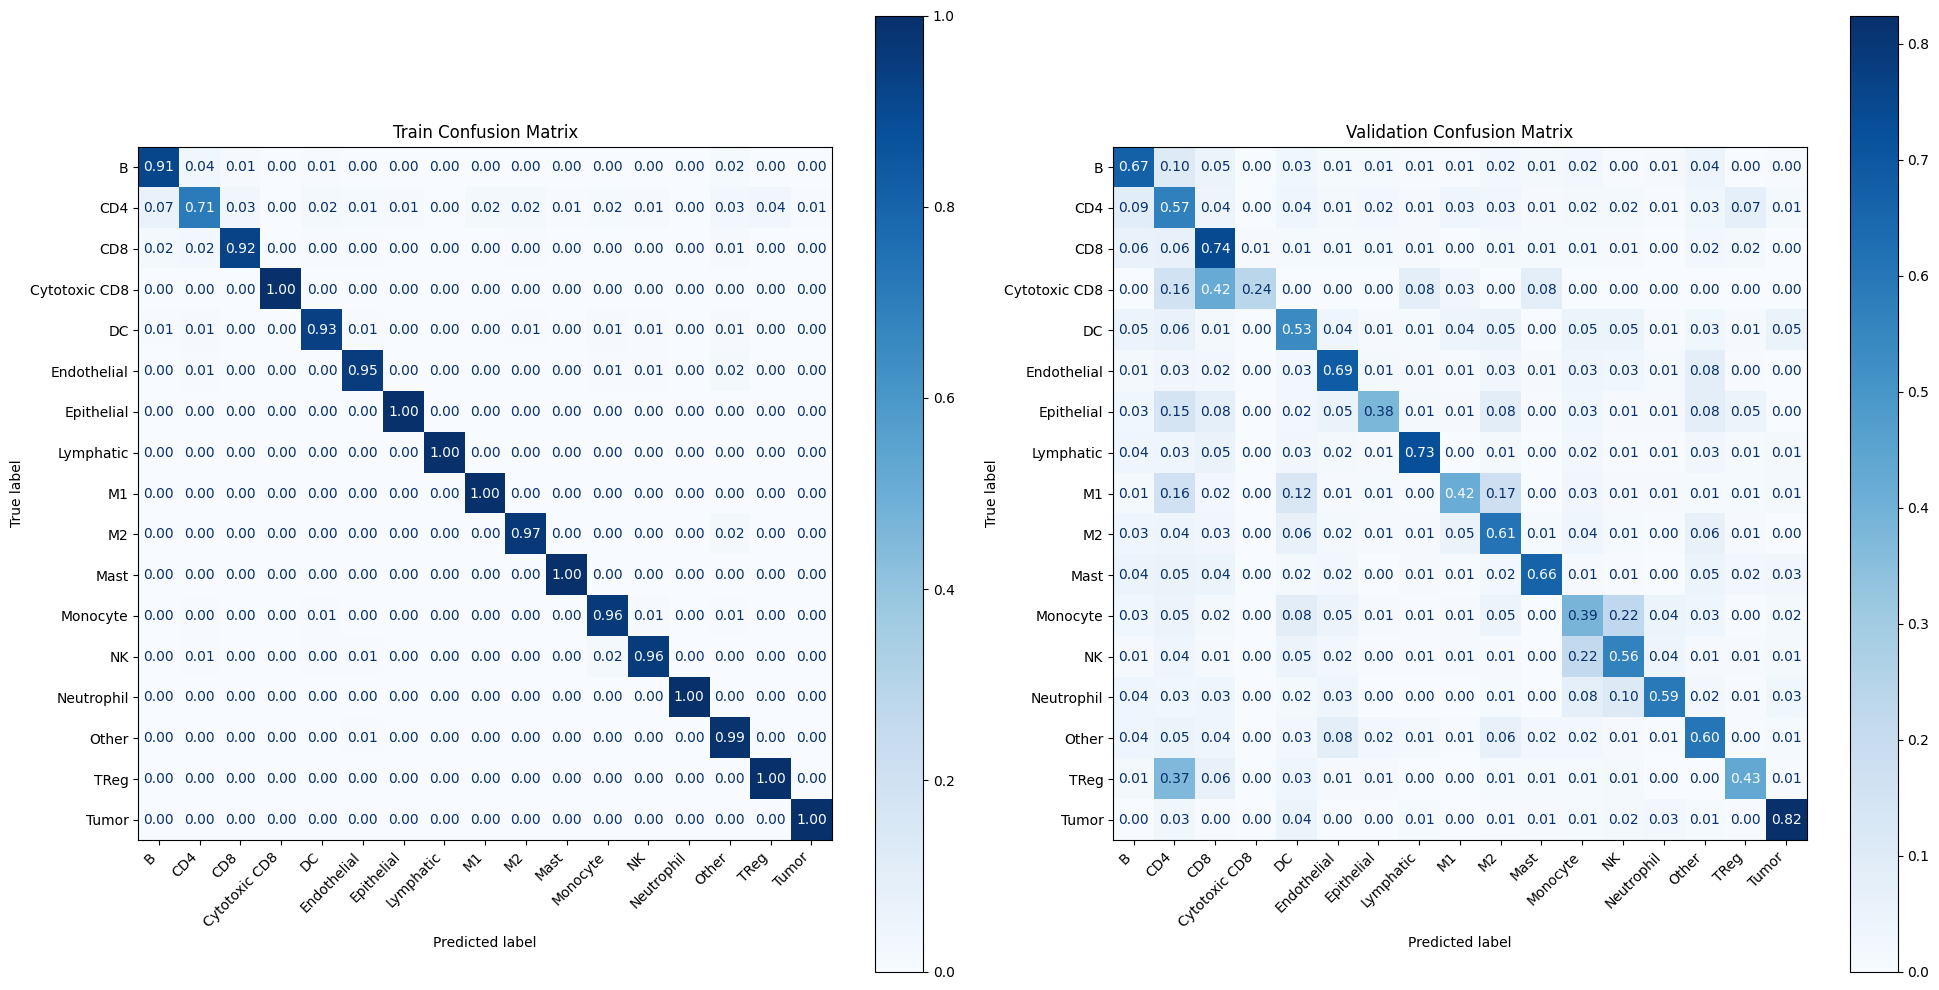

Saved metrics to /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/MCA/z_RUNS/CODEX_cHL_SIMPLE/metrics.json


In [13]:
import json

# Get probabilities and predictions
train_proba = clf.predict_proba(train_features)
val_proba = clf.predict_proba(val_features)

# Top-1 predictions
train_pred_num = train_proba.argmax(axis=1)
val_pred_num = val_proba.argmax(axis=1)

# Top-2 predictions
train_top2 = np.argsort(train_proba, axis=1)[:, -2:]
val_top2 = np.argsort(val_proba, axis=1)[:, -2:]

# Calculate metrics...
train_top2_acc = np.mean([train_labels[i] in train_top2[i] for i in range(len(train_labels))])
val_top2_acc = np.mean([val_labels[i] in val_top2[i] for i in range(len(val_labels))])

def top2_balanced_accuracy(y_true, top2_preds, n_classes):
    recalls = []
    for c in range(n_classes):
        mask = (y_true == c)
        if mask.sum() == 0:
            continue
        correct = np.sum([y_true[i] in top2_preds[i] for i in np.where(mask)[0]])
        recalls.append(correct / mask.sum())
    return np.mean(recalls)
train_top2_bal_acc = top2_balanced_accuracy(train_labels, train_top2, len(label_encoder.classes_))
val_top2_bal_acc = top2_balanced_accuracy(val_labels, val_top2, len(label_encoder.classes_))

train_pred_str = label_encoder.inverse_transform(train_pred_num)
val_pred_str = label_encoder.inverse_transform(val_pred_num)

# Standard metrics
train_acc = accuracy_score(train_labels, train_pred_num)
train_bal_acc = balanced_accuracy_score(train_labels, train_pred_num)
train_precision = precision_score(train_labels, train_pred_num, average='weighted')
train_f1 = f1_score(train_labels, train_pred_num, average='weighted')

val_acc = accuracy_score(val_labels, val_pred_num)
val_bal_acc = balanced_accuracy_score(val_labels, val_pred_num)
val_precision = precision_score(val_labels, val_pred_num, average='weighted')
val_f1 = f1_score(val_labels, val_pred_num, average='weighted')

# Print metrics...
print(f"\n=== Train Set Performance ===")
print(f"Top-1 Accuracy: {train_acc:.4f}")
print(f"Top-2 Accuracy: {train_top2_acc:.4f}")
print(f"Top-1 Balanced Accuracy: {train_bal_acc:.4f}")
print(f"Top-2 Balanced Accuracy: {train_top2_bal_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"F1 Score: {train_f1:.4f}")

print(f"\n=== Validation Set Performance ===")
print(f"Top-1 Accuracy: {val_acc:.4f}")
print(f"Top-2 Accuracy: {val_top2_acc:.4f}")
print(f"Top-1 Balanced Accuracy: {val_bal_acc:.4f}")
print(f"Top-2 Balanced Accuracy: {val_top2_bal_acc:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Confusion matrices
train_cm = confusion_matrix(train_labels_str, train_pred_str, labels=label_encoder.classes_, normalize='true')
val_cm = confusion_matrix(val_labels_str, val_pred_str, labels=label_encoder.classes_, normalize='true')

# Plot...
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=label_encoder.classes_)
disp_train.plot(ax=axes[0], cmap='Blues', values_format='.2f', xticks_rotation=45)
axes[0].set_title('Train Confusion Matrix')


disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=label_encoder.classes_)
disp_val.plot(ax=axes[1], cmap='Blues', values_format='.2f', xticks_rotation=45)
axes[1].set_title('Validation Confusion Matrix')

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')   # or 'center', 'left'
        label.set_verticalalignment('top')       # or 'center', 'bottom'
        
plt.tight_layout()
plt.savefig(f'/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/MCA/z_RUNS/CODEX_cHL_SIMPLE/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

metrics = {
    'train': {
        'top1_accuracy': float(train_acc),
        'top2_accuracy': float(train_top2_acc),
        'top1_balanced_accuracy': float(train_bal_acc),
        'top2_balanced_accuracy': float(train_top2_bal_acc),
        'precision': float(train_precision),
        'f1': float(train_f1),
        'n_samples': len(train_features)
    },
    'val': {
        'top1_accuracy': float(val_acc),
        'top2_accuracy': float(val_top2_acc),
        'top1_balanced_accuracy': float(val_bal_acc),
        'top2_balanced_accuracy': float(val_top2_bal_acc),
        'precision': float(val_precision),
        'f1': float(val_f1),
        'n_samples': len(val_features)
    },
    'classes': list(label_encoder.classes_),
    'n_classes': len(label_encoder.classes_),
    'feature_dim': int(train_features.shape[1])
}
        
with open(f'/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/MCA/z_RUNS/CODEX_cHL_SIMPLE/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"Saved metrics to /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/MCA/z_RUNS/CODEX_cHL_SIMPLE/metrics.json")